In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from config.path import PATH # config/path.py to manage your dataset paths
coco_path = PATH["COCO"]

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

2022-07-18 09:51:25.460805: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-18 09:51:27.982395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 09:51:27.999097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 09:51:27.999516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


import libraries

In [4]:
from data.ssd import SSDDataset
from models.SSD import SSD300, EfficientSSD300
from models.RetinaNet import RetinaNet
from utils.visualize import visualize_detections

2022-07-18 09:51:28.248571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-18 09:51:28.250323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 09:51:28.250828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 09:51:28.251222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

### Load COCO dataset

In [5]:
image_path = f"{coco_path}/images/train2017"
annotation_path = f"{coco_path}/annotations/instances_train2017.json"
train_dataset = SSDDataset(image_path, annotation_path, num_examples=50, shuffle=False)

loading annotations into memory...
Done (t=19.88s)
creating index...
index created!


Visualize a single data sample.

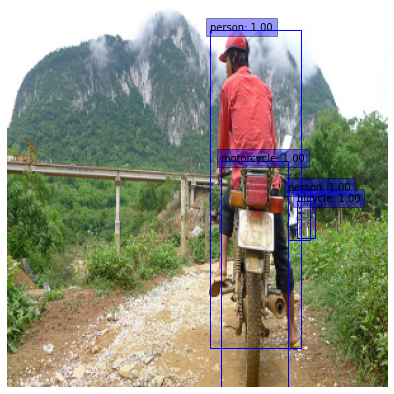

<AxesSubplot:>

In [6]:
image, boxes, labels = train_dataset.get_item(train_dataset.image_ids[0])
classes = [train_dataset.labels[int(label)] for label in labels]
visualize_detections(image, boxes, classes, tf.ones_like(labels))

### Load your model

In [10]:
# SSD300
num_classes = train_dataset.num_classes()
model = SSD300(num_classes)

### Load data pipeline

Each sample which consist of (image, bounding boxes, classes), will be converted into image, ground truths of anchors (N, anchor, 5). 5 is [dx,dy,dw,dh,class_id]

In [11]:
train_tfds = train_dataset.load_tfds(batch_size=1, model=model)

In [36]:
items = next(iter(train_tfds))
for item in items:
    print(item.shape)

(1, 300, 300, 3)
(1, 8732, 5)


### training

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, clipnorm=0.001)
model.fit(train_tfds, epochs=5, verbose=1,)

### load a pretrained model and visualize inference

In [13]:
weights_dir = "experiments/SSD300/20220716-160657"
latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

In [37]:
images = items[0]
print(images.shape)

(1, 300, 300, 3)


In [38]:
inference_model = model.inference(confidence_threshold=0.3)
detections = inference_model(images)

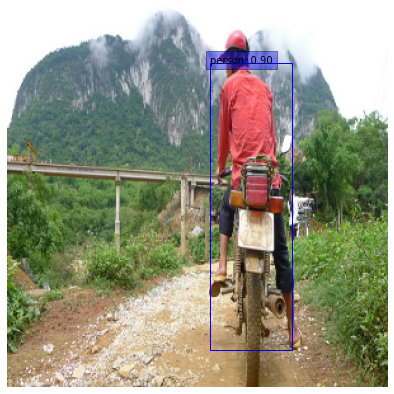

In [39]:
from utils.visualize import visualize_inference
visualize_inference(images[0], train_dataset.labels, detections)